In [1]:
import numpy as np
from scipy import stats
from sklearn.metrics import mutual_info_score
import math
from pyitlib import discrete_random_variable as drv
import sys
sys.path.insert(1, '/Users/chengpeng/Desktop/Research/STAT/CIBer')
import comonotonic as cm
import random
import tool_box as tb
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# pass in pearson corr_coef, P(Y=0|X1,X2) for 4 value combinations of X1 X2
def generator(rho, p_00, p_01, p_10, p_11, amount):
    # percent_abc means P(X1=a,X2=b,Y=c)
    data = list()
    percent_000 = p_00*(1+rho)/4
    add_000 = [[0,0,0] for i in range(int(amount*percent_000))]
    data += add_000
    percent_001 = (1-p_00)*(1+rho)/4
    add_001 = [[0,0,1] for i in range(int(amount*percent_001))]
    data += add_001
    percent_010 = p_01*(1-rho)/4
    add_010 = [[0,1,0] for i in range(int(amount*percent_010))]
    data += add_010
    percent_011 = (1-p_01)*(1-rho)/4
    add_011 = [[0,1,1] for i in range(int(amount*percent_011))]
    data += add_011
    percent_100 = p_10*(1-rho)/4
    add_100 = [[1,0,0] for i in range(int(amount*percent_100))]
    data += add_100
    percent_101 = (1-p_10)*(1-rho)/4
    add_101 = [[1,0,1] for i in range(int(amount*percent_101))]
    data += add_101
    percent_110 = p_11*(1+rho)/4
    add_110 = [[1,1,0] for i in range(int(amount*percent_110))]
    data += add_110
    percent_111 = (1-p_11)*(1+rho)/4
    add_111 = [[1,1,1] for i in range(int(amount*percent_111))]
    data += add_111
    return np.array(data)

In [3]:
def compute_cmi(rho, p_00, p_01, p_10, p_11, amount):
    data = generator(rho, p_00, p_01, p_10, p_11, amount)
    X1 = list(data[:,0].flatten())
    X2 = list(data[:,1].flatten())
    Y = list(data[:,2].flatten())
    return drv.information_mutual_conditional(X1,X2,Y)

In [4]:
def rmse(y, y_pred, y_prob_dist):
    mse = 0
    for i in range(y_prob_dist.shape[0]):
        real_prob_dist = np.array([0 for j in range(y_prob_dist.shape[1])])
        real_prob_dist[y[i]] = 1
        pred_prob_dist = y_prob_dist[i]
        mse += sum([j**2 for j in real_prob_dist-pred_prob_dist])
    return math.sqrt(0.5*mse/len(y))

In [3]:
def ciber_experiment(rho, p_00, p_01, p_10, p_11, amount):
    data = generator(rho, p_00, p_01, p_10, p_11, amount)
    np.random.seed(0)
    np.random.shuffle(data)
    X = data[:,:-1]
    Y = data[:,-1]
    cont_col = [i for i in range(X.shape[1])]
    categorical = []
    discrete_feature_val = None
    allocation_book = None
    min_corr = rho/2 # so that X1 X2 always comonotonic
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
    ciber = cm.clustered_comonotonic(X_train,Y_train,discrete_feature_val,cont_col,categorical,
                                     min_corr,None,corrtype = 'pearson',discrete_method = "auto",
                                     allocation_book = allocation_book)
    ciber.run()
    ciber_predict = ciber.predict(X_test)

    ##########
    ciber_nb = cm.clustered_comonotonic(X_train,Y_train,discrete_feature_val,cont_col,categorical,
                                    1,None,corrtype = 'pearson',discrete_method = "auto",
                                    allocation_book = allocation_book)
    ciber_nb.run()
    ciber_nb_predict = ciber_nb.predict(X_test)

    return accuracy_score(Y_test, ciber_predict), accuracy_score(Y_test, ciber_nb_predict)

In [4]:
p_00 = 0.25
p_01 = 0.75
p_10 = 0.75
p_11 = 0.25
amount = 10000

In [5]:
ciber_rmse = list()
nb_rmse = list()
rho_list = np.linspace(0,1,num=50)
for rho in np.linspace(0,1,num=50):
    ciber_result, nb_result = ciber_experiment(rho, p_00, p_01, p_10, p_11, amount)
    ciber_rmse.append(ciber_result)
    nb_rmse.append(nb_result)

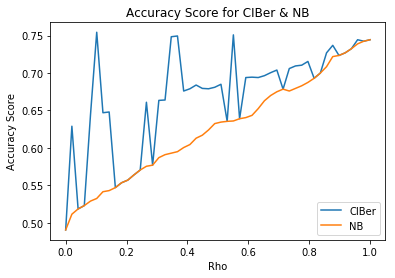

In [6]:
plt.plot(rho_list, ciber_rmse, label = 'CIBer')
plt.plot(rho_list, nb_rmse, label = 'NB')
plt.xlabel('Rho')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score for CIBer & NB')
plt.legend()
plt.show()